#  Machine Learning for Functional Connectivity analysis:

This tutorial is meant to give you some tools to start applying some machine learning to your problems, but it will not cover what machine learning is and what different models are doing. 

1. How to download and load COBRE resting state functional datasets.
2. How to measure connectomes from brain data decomposed to functionally
   defined regions.
3. SVM based classification of healthy subjects and schizophrenic datasets
4. All to all neural network for classification

Before starting, let's import the libraries that we will need for the first part of the tutorial.

In [1]:
#Importing librairies
import matplotlib.pyplot as plt

import numpy   as np
import sklearn as sk
import csv
import os

from nilearn import datasets, input_data

%matplotlib inline

## Loading resting state functional datasets

In this tutorial, we are interested to use a light version of the COBRE datasets, which can be downloaded at the following link;  https://figshare.com/articles/COBRE_preprocessed_with_NIAK_0_17_-_lightweight_release/4197885

Make sure you copy this tutorial with the extrated files. If you are using mac or Linux, you can unzip all the files in the 4197885.zip file by using gzip -d *.gz in the command line.

In [2]:
#Data path (might need to be changed depending on where you put your unzipped data files)
dPath = os.getcwd() + '/data/'

#Nifti files
fmriFiles = [dPath + file for file in os.listdir(dPath) if '.nii' in file] # cobre_data.func[:2] # 

#Phenotypes file 
pheFile = dPath + 'phenotypic_data.tsv'

#Number of subjects
N = len(fmriFiles)

#Reading phenotype file
with open(pheFile) as f:
    reader = csv.reader(f, delimiter="\t")
    phe = np.stack(list(reader))

#Subject ID
ID = phe[1:,0]

#Subject label (control or patient)
Y  = phe[1:,4];   Y[Y == 'Control'] = int(0);   Y[Y == 'Patient'] = 1 ; Y = Y.astype(int)

#Sorting based on ID
sortIdx = np.argsort(ID)

#Sorting phenotypes
ID = ID[sortIdx]; Y = Y[sortIdx];

#Sorting fmri files
fmriFiles = [file for i in ID for file in fmriFiles if i in file]

print('First file         : {}'.format(fmriFiles[0]))
print('Number of subjects : {}'.format(N))

First file         : /home/phabc/Main/Programmation/Hackathons/uwoBrainhack2017/neuralLace_BH2017/MLtutorial/data/fmri_0040000.nii
Number of subjects : 146


In [3]:
# asymmetric version of clusters can be selected using version='asym'
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='asym')

# By default are scales are fetched and stored in output assigned variable 'parcellations'
# To launch specific scale of networks
networks_122 = parcellations['scale122']
# To launch specific scale of networks
networks_444 = parcellations['scale444']

/home/phabc/anaconda3/envs/tfcpu/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/phabc/anaconda3/envs/tfcpu/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


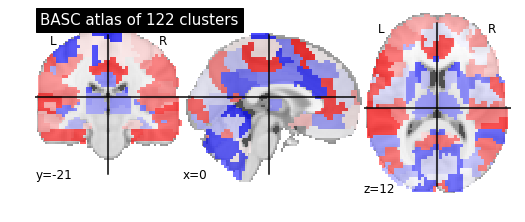

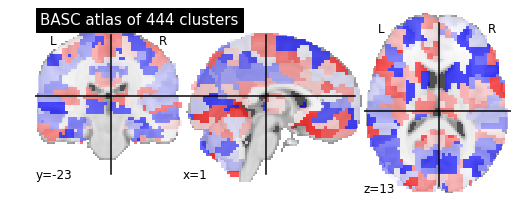

In [4]:
# To view the atlas, we can use of nilearn plotting utilities to see what has
# been fetched and how does it look like. For this, we import plotting and use
# `plot_roi` to visualize the atlas maps in 3D and colormap of our own choice
from nilearn import plotting

#Network divided into 122 clusters
plotting.plot_roi(networks_122, cmap=plotting.cm.bwr,
                  title='BASC atlas of 122 clusters')

#Network divided into 444 clusters
plotting.plot_roi(networks_444, cmap=plotting.cm.bwr_r,
                 title='BASC atlas of 444 clusters')


### Extracting subject specific timeseries signals from brain parcellations
Computing mask from the data, filtering, extracting data from the in-mask voxels can be processed easily by using nilearn classes such as NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker which can be imported from nilearn.input_data module.

The advantage of using such tools from this module is that we can restrict our analysis to mask specific voxels timeseries data. For instance, class NiftiMasker can be used to compute mask over the data and apply preprocessing steps such as filtering, smoothing, standardizing and detrending on voxels timeseries signals. This type of processing is very much necessary, particularly during resting state fMRI data analysis.

Additional to NiftiMasker, classes NiftiMapsMasker and NiftiLabelsMasker, can be used to extract subject specific timeseries signals on each subject data provided with the atlas maps (3D or 4D) comprising of specific brain regions. NiftiMapsMasker operated on 4D atlas maps, can be used to extract signals from each 4th dimensional map using least squares regression. Whereas, NiftiLabelsMasker operated on 3D maps denoted as labels image, can be used to extract averaged timeseries from group of voxels that correponds to each label in the image.

In [5]:
labels_masker = input_data.NiftiLabelsMasker(
    
                         labels_img     = networks_122,    # brain atlas,
                         smoothing_fwhm = 6.,              # Smoothing
                         standardize    = True,            # Standardizing or not
                         detrend        = True,            # Apply detrending
                         t_r            = 2.5,             # Repetition time for filtering
                         low_pass       = 0.1,             # Low-Pass Filtering
                         high_pass      = 0.01,            # High-Pass Filtering
    
                         )

In [6]:
timeSeries = []

for funcImg in fmriFiles:
    
    #print(funcImg)
    signals = labels_masker.fit_transform(funcImg)
    timeSeries.append(signals)
    

/home/phabc/anaconda3/envs/tfcpu/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


In [7]:
#Shape of timeSeries, to see number of time points and parcelations
timeSeries[0].shape

(150, 122)

## Connectomes Estimation

Computing connectomes using connectivity measures such as correlation, partial correlation and tangent methods with Ledoit Wolf shrinkage covariance estimator. We import class `ConnectivityMeasure` from nilearn.connectome module and covariance estimator `LedoitWolf` from scikit learn to measure connectomes using extracted subjects timeseries signals between each brain parcellations.

In [8]:
from nilearn.connectome import ConnectivityMeasure

corr    = ConnectivityMeasure(kind='correlation')
corrMat = corr.fit_transform(timeSeries)

/home/phabc/anaconda3/envs/tfcpu/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Plotting correlation matrices

Plotting connectome matrices. We calculate mean of all the matrices of each measure and use mean matrices to visualize the connectome interactions between 122 brain atlas regions. We make use of plotting from nilearn which is already imported.

Calculate mean of all the connectivity matrices for each measure. For tangent based measure, mean is already pre-computed during connectivity measures. So, we directly take mean in `mean_` attribute and for other measures we compute voluntarily.

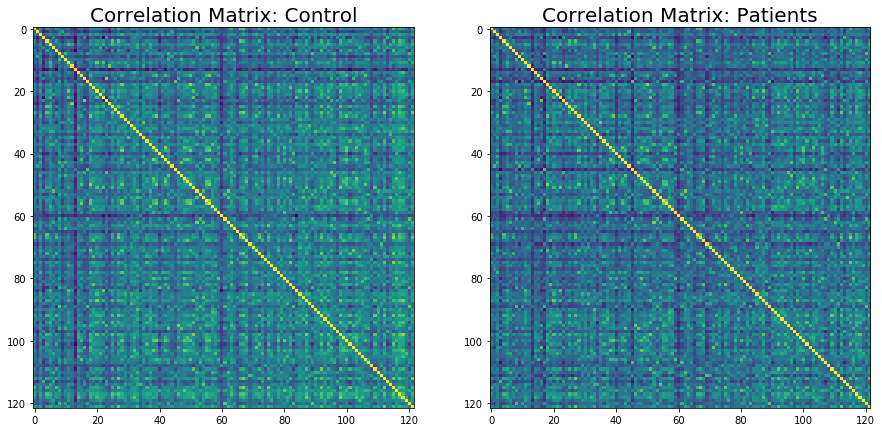

In [9]:
#Average correlation matrix for control
meanControlCorr = corrMat[Y == 0, ...].mean(axis=0)

#Average correlation matrix for patients
meanSczCorr = corrMat[Y == 1, ...].mean(axis=0)

#Initializing figure
plt.figure(figsize = (15,15))

#Plotting Control
plt.subplot(1,2,1)
plt.title('Correlation Matrix: Control',  fontsize = 20)
plt.imshow(meanControlCorr)

#PLotting patients
plt.subplot(1,2,2)
plt.title('Correlation Matrix: Patients', fontsize = 20)
plt.imshow(meanSczCorr)

plt.show()

# Prediction using Support Vector Classifier

Let's use our correlation matrices to classify samples between schizophrenia and healthy subjects.

Our first classification is based on a Support Vector Machine linear classifier. We perform a Stratified Shuffle Split mechanism where we train the classifier on 75% of the data size and test the classifier on the remaining 25%. To see how well our classifier does, we will look at the the average roc and auc classification scores.

For this model, we will use the scikit-learn library which contains some basic and easy to use machine learning classifiers.

In [10]:
#Shape of the correlation matrices (AKA our connectivity matrix)
corrMat.shape

(146, 122, 122)

For our SVM, the shape of our data is important. Usually, images are stacked into a single vector and here, because our correlation matrix is symmetric (and diagonal is equal to 1), we will only consider half of it.

In [11]:
from nilearn.connectome import sym_to_vec

# Flattening our correlation matrix
corrMat_ = sym_to_vec(corrMat)
corrMat_.shape

(146, 7503)

We import SVC, StratifiedShuffleSplit, cross_val_score from scikit learn for classification problem using cross validation procedure and import sym_to_vec from nilearn.connectome module to compute connectivity coefficients for each measure to use them in classification.

In [12]:
from sklearn.svm                   import SVC
from sklearn.cross_validation      import StratifiedShuffleSplit, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Setting parameters
nIters   = 500        # Number of training iterations
testSize = 0.25       # Size of test set (in pourcentage)
kern     = 'linear'   # Kernel function for SVM (type ?SVC for more options & information)
weight   = 'balanced' # Weight associated with each label. Useful when one label has more examples. 

In [13]:
#Initialize Stratified Shuffle Split
stratShuffle = StratifiedShuffleSplit(Y, n_iter = nIters, test_size = testSize)

#Creating the SVM classifier
svc = SVC(kernel = kern, class_weight = weight)

#Cross validation and training:
#   Here we specify the model (svc), the data (corrMat_), the labels (Y) 
#   and our cross-validation method (stratShuffle).
cross_validation = cross_val_score(svc, corrMat_, 
                                   Y, cv = stratShuffle)

In [14]:
print("Classification scores '%s': %1.2f +/- %1.2f" % ('correlation', cross_validation.mean(),
                                                       cross_validation.std()))

Classification scores 'correlation': 0.70 +/- 0.06


### Comparing Functionnal Connectivity using Tangent Embedding

In [15]:
#Connectivity Based on Tangent Embedding
connTan    = ConnectivityMeasure(kind='tangent')
connTanMat = connTan.fit_transform(timeSeries)

#SVM
connTanMat_      = sym_to_vec(connTanMat)
cross_validation = cross_val_score( svc, connTanMat_, 
                                    Y,   cv = stratShuffle )

In [16]:
print("Classification scores '%s': %1.2f +/- %1.2f" % ('tangent', cross_validation.mean(),
                                                       cross_validation.std()))

Classification scores 'tangent': 0.78 +/- 0.06


# Deep Neural Network

For this part, you will need to install Keras and Tensorflow. This is a simple neural network, but you can find plenty of more detailed tutorials for various architecture (CNN, RNN, GAN, etc.). We are using Keras here, which act as a wraparound of tensorflow, since it offers a gentler introduction to deeplearning. It's flexible enough to be fun, but might not be appropriate for developing new neural network architectures. Keras is also now officially part of Tensorflow's core (since TF 1.0). 

Note that the current models are not fine tuned for the current problem, hence their ok performance, so feel free to modify them and play with the hyperparameters! As a general rule, you want to avoid hitting the performance ceiling with the training set, which would show that the model might be prone to overfitting. You can either reduce the size of the network (number of units or layers), but even better is to regularize the network. The idea is that more units and layers leads to more flexibility in terms of solution, but the solution found should better be a good one and not just overfitting. 

In general, when you play hyperparameters, try to be mindful and diligent. For instance, don't change all the parameters at once, or you won't know what improved the training! Try to understand why some changes are better than others (number of units, layers, batch normalization, transfer function, regularization, etc.) Note that the preprocessing of the data can have a significant impact. It is important to understand how sucessful networks are built, especially when you will try to implement models for more complex tasks.

For optimizing the hyperparameters in a smart fashion, check out spearmint ; https://github.com/HIPS/Spearmint (but try by hand at first to get a better feeling of what each piece does).

In [17]:
#Importing
from keras.models        import Sequential
from keras.layers        import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, LSTM, Activation, normalization
from keras.optimizers    import SGD, RMSprop
from keras.preprocessing import sequence
from keras.utils         import np_utils
from keras.regularizers  import l2, activity_l2

from keras.datasets import mnist

Using TensorFlow backend.


In [18]:
#Defining some dataset parameters
testProp  = 0.25 # Size of test set (as a proportion)
nClass    = 2    # Number of classes (control vs patient)

### Formatting datasets
In order to use Keras (and Tensorflow) we need to do a little bit of work. Just like sklearn, Keras and Tensorflow want to have the data in a certain format. Here, we will need to specify which examples belongs to the training set and which examples belong to the testing set. We will also need to change our label vector so that it becomes a one hot encoding matrix (truth table, with each column being a class). 

In [19]:
#Converting Y label as one-hot encoding matrix
Yhot = np.zeros((N, nClass))
Yhot[np.arange(N), Y] = 1

#Showing difference
print('Y = \n{} \n\n     '.format(Y))
print('Yhot = \n{} \n ...'.format(Yhot[:20,:]))

Y = 
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0
 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0] 

     
Yhot = 
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 
 ...


For the data X, we need to specify which part of the data will be used as a training set and which will be used as a testing set. Ideally, we want to randomly select examples, since we don't want to always have the same training and testing set. One would need to repeat this process multiple times to have a proper cross-validation.

In [20]:
#Copying data to use (lazyness)
X = connTanMat_.copy()

#Shuffling data
idxShuffle = np.random.permutation(N)

#Number of training examples
trainSize  = round(N*(1-testProp))

#Training examples
xTrain = X[idxShuffle[:trainSize],:]
yTrain = Yhot[idxShuffle[:trainSize],:]

#Testing examples
xTest = X[idxShuffle[trainSize:],:]
yTest = Yhot[idxShuffle[trainSize:],:]

### Building Neural Network
Now that our data is in the right format, we can build our (simple) neural network! We will need to specify the number of layers, the number of units per layer, how the weights are initialized and the tranfer function of the units. We will also add some dropout operations to regularize the network (preventing overfitting and better score on test set).

In [21]:
#Network hyper-parameters

#Number of datapoints per example
xDim = xTrain.shape[1] 

#Number of units per layer
nUnits = [100, 200, 30, 2]

#Input dimensions for our 3 layers
inDim  = [xDim, nUnits[0], nUnits[1], nUnits[2]]

#Activation function
actFct = ['relu', 'relu', 'sigmoid']

#Initialization
initW = 'normal'

#Dropout probability (regularization)
dropProb = 0.3

Creating the network. Here, we will put back to back our layers and dropout operations.

In [22]:
#Initializing our architecture as a feedforward network
model = Sequential()

#Creating our input later
model.add(Dense(output_dim = nUnits[0], input_dim = inDim[0], init = initW, activation = actFct[0]) )
model.add(Dropout(dropProb))
model.add(normalization.BatchNormalization(epsilon=0.001))

#Creating our hidden layer
model.add(Dense(output_dim = nUnits[1], input_dim = inDim[1], init = initW, activation = actFct[1]) )
model.add(Dropout(dropProb))
model.add(normalization.BatchNormalization(epsilon=0.001))

#Creating our hidden layer
model.add(Dense(output_dim = nUnits[2], input_dim = inDim[2], init = initW, activation = actFct[1]) )
model.add(Dropout(dropProb/2))
model.add(normalization.BatchNormalization(epsilon=0.001))

#Creating our output layer
model.add(Dense(output_dim = nUnits[3], input_dim = inDim[3], init = initW, activation = actFct[2]) )

#Building the network with training
model.compile(optimizer=SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 100)           750400      dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 100)           200         dropout_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 200)           20200       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [23]:
#Training parameters
nEpoch    = 100  # Number of training epochs (number of batches)
batchSize = 64   # Number of training examples per batch


# Train
history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest),
                    nb_epoch   = nEpoch, 
                    batch_size = batchSize, 
                    verbose    = 1)

Train on 110 samples, validate on 36 samples
Epoch 1/100
110/110 [==============================] - 0s - loss: 0.6992 - acc: 0.5091 - val_loss: 0.6911 - val_acc: 0.6389
Epoch 2/100
110/110 [==============================] - 0s - loss: 0.7007 - acc: 0.4818 - val_loss: 0.6916 - val_acc: 0.5833
Epoch 3/100
110/110 [==============================] - 0s - loss: 0.6908 - acc: 0.5455 - val_loss: 0.6922 - val_acc: 0.5278
Epoch 4/100
110/110 [==============================] - 0s - loss: 0.6938 - acc: 0.4636 - val_loss: 0.6927 - val_acc: 0.5556
Epoch 5/100
110/110 [==============================] - 0s - loss: 0.6750 - acc: 0.6455 - val_loss: 0.6930 - val_acc: 0.4722
Epoch 6/100
110/110 [==============================] - 0s - loss: 0.6817 - acc: 0.6364 - val_loss: 0

In [24]:
# Evaluate on the test set (unseen data)
evaluation = model.evaluate(xTest, yTest, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

32/36 [=========================>....] - ETA: 0sSummary: Loss over the test dataset: 0.77, Accuracy: 0.58


# Convolutional Neural Network

Here, we will build a convolutional neural network, just to show how it's done. However, I did not optimize it for the present problem, hence it's relatively poor performance. CNN might not be appropriate for this type of "images" either, since there is little structure in them compared to natural images.

In [25]:
#Defining some dataset parameters
testProp  = 0.3 # Size of test set (as a proportion)
nClass    = 2    # Number of classes (control vs patient)

In [26]:
#Model parameters
img_rows, img_cols = 122, 122         # Input image dimensions (since we picked network 122)
pool_size          = (1, 1)           # Size of pooling area for max pooling
prob_drop_conv     = 0.5              # Dropout probability for dropout @ conv layer
prob_drop_hidden   = 0.5              # Dropout probability for dropout @ fc layer

input_shape = (img_rows, img_cols, 1)

For the CNN the need to put the X in 4 dimentions (N,122,122,1) for the training.

In [27]:
#Copying data to use (lazyness)
X = connTanMat.copy()

#Shuffling data
idxShuffle = np.random.permutation(N)

#Number of training examples
trainSize  = round(N*(1-testProp))

#Training examples
xTrain = X[idxShuffle[:trainSize], ...].reshape(trainSize, img_rows, img_cols, 1)
yTrain = Yhot[idxShuffle[:trainSize],:]

#Testing examples
xTest = X[idxShuffle[trainSize:], ...].reshape(N-trainSize, img_rows, img_cols, 1)
yTest = Yhot[idxShuffle[trainSize:],:]

Building the model

In [28]:
# Convolutional model
model = Sequential()

# conv1 layer
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu', 
                        input_shape=input_shape, init=initW))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# conv2 layer
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', init=initW))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Dropout(prob_drop_conv))

# conv3 layer
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu', init=initW))
model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), border_mode='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

# fc1 layer
model.add(Dense(500, activation='relu', init=initW))
model.add(Dropout(prob_drop_hidden))

# fc1 layer
model.add(Dense(100, activation='relu', init=initW))
model.add(Dropout(prob_drop_hidden))

# fc2 layer
model.add(Dense(2, activation='softmax', init=initW))

opt = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 122, 122, 32)  320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 61, 61, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 61, 61, 32)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 61, 61, 64)    18496       dropout_4[0][0]                  
___________________________________________________________________________________________

In [29]:
#Training parameters
nEpoch    = 100  # Number of training epochs (number of batches)
batchSize = 32   # Number of training examples per batch

# Train
history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest),
                    nb_epoch   = nEpoch, 
                    batch_size = batchSize, 
                    verbose    = 1)

Train on 102 samples, validate on 44 samples
Epoch 1/100
102/102 [==============================] - 4s - loss: 0.7058 - acc: 0.5000 - val_loss: 0.7267 - val_acc: 0.4318
Epoch 2/100
102/102 [==============================] - 5s - loss: 0.7022 - acc: 0.5294 - val_loss: 0.6957 - val_acc: 0.4318
Epoch 3/100
102/102 [==============================] - 5s - loss: 0.6959 - acc: 0.4804 - val_loss: 0.6926 - val_acc: 0.4545

In [30]:
# Evaluate
evaluation = model.evaluate(xTest, yTest, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

44/44 [==============================] - 0s     
Summary: Loss over the test dataset: 0.89, Accuracy: 0.75


# Recurrent Neural Network

Here, we will construct a reccurent neural network that will use the timeseries themselves instead of using the previously defined correlation matrices. More specifically, we will use a LSTM (Long-Short-Term Memory) model, which have proven to be very successful for considering long term dependencies.

First, we need to organize the timeseries previously extracted into training and test sets. Note that X needs to be of form [samples, time features].

In [40]:
#Defining some dataset parameters
testProp  = 0.2 # Size of test set (as a proportion)
nClass    = 2    # Number of classes (control vs patient)

#Model parameters
LSTMsize = 500  # Number of LSTM units
hidSize  = 200  # Size of hidden layer before output
l2Wreg   = 0.1  # L2 regularization coefficient for parameters

dropProb = 0.3 #Hidden layer dropout probability

In [37]:
#Taking subjects with 150 time points (1 has 67 timepoints).
X  = np.stack([time for time in timeSeries if time.shape[0] == 150 ])

# Number of subject included
Nx = X.shape[0]

#Shuffling data
idxShuffle = np.random.permutation(Nx)

#Number of training examples
trainSize  = round(Nx*(1-testProp))

#Training examples
xTrain = X[idxShuffle[:trainSize], :]
yTrain = Yhot[idxShuffle[:trainSize],:]

#Testing examples
xTest = X[idxShuffle[trainSize:], :]
yTest = Yhot[idxShuffle[trainSize:],:]

#Shapes
T  = xTrain.shape[1] # Number of timepoints
P  = xTrain.shape[2] # Number of features (122 here since we are using 122 clusters map)

print('X shape: {}'.format(X.shape)) #To verify if right format

X shape: (145, 150, 122)


In [41]:
model = {}

#Feedforward
model = Sequential()  

#LSTM Layer
model.add(LSTM(LSTMsize, input_shape = (T, P), return_sequences = True, W_regularizer = l2(l2Wreg)))  
model.add(Dropout(dropProb))

#LSTM Layer
model.add(LSTM(LSTMsize, W_regularizer = l2(l2Wreg)))  
model.add(Dropout(dropProb))

#Hidden Layer
model.add(Dense(hidSize, activation= 'relu'))
model.add(Dropout(dropProb*2))

#Output layer
model.add(Dense(nClass))
model.add(Activation('softmax'))

#Training
model.compile(loss="categorical_crossentropy", optimizer="RMSprop",  metrics=['accuracy']) 

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_5 (LSTM)                    (None, 150, 500)      1246000     lstm_input_3[0][0]               
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 150, 500)      0           lstm_5[0][0]                     
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 500)           2002000     dropout_15[0][0]                 
____________________________________________________________________________________________________
dropout_16 (Dropout)             (None, 500)           0           lstm_6[0][0]                     
___________________________________________________________________________________________

In [ ]:
#Training model
nEpoch    = 200 # Number of training epochs (number of batches)
batchSize = 16 # Number of batches

#Run
history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest),
                    nb_epoch   = nEpoch, 
                    batch_size = batchSize, 
                    verbose    = 2)

Train on 116 samples, validate on 29 samples
Epoch 1/200
18s - loss: 0.7684 - acc: 0.4138 - val_loss: 0.6928 - val_acc: 0.5172
Epoch 2/200
21s - loss: 0.7369 - acc: 0.5000 - val_loss: 0.7158 - val_acc: 0.4828
Epoch 3/200
20s - loss: 0.7520 - acc: 0.4310 - val_loss: 0.6988 - val_acc: 0.4828
Epoch 4/200
22s - loss: 0.7366 - acc: 0.4828 - val_loss: 0.7041 - val_acc: 0.4828
Epoch 5/200
24s - loss: 0.7247 - acc: 0.5259 - val_loss: 0.7507 - val_acc: 0.4828
Epoch 6/200
26s - loss: 0.7803 - acc: 0.4310 - val_loss: 0.6947 - val_acc: 0.4828
Epoch 7/200
24s - loss: 0.7611 - acc: 0.5603 - val_loss: 0.6937 - val_acc: 0.5172
Epoch 8/200
26s - loss: 0.7469 - acc: 0.4828 - val_loss: 0.6953 - val_acc: 0.4828
Epoch 9/200
24s - loss: 0.7511 - acc: 0.3793 - val_loss: 0.6931 - val_acc: 0.5172
Epoch 10/200
23s - loss: 0.7266 - acc: 0.4914 - val_loss: 0.6999 - val_acc: 0.4828
Epoch 11/200
23s - loss: 0.7292 - acc: 0.5172 - val_loss: 0.6969 - val_acc: 0.4828
Epoch 12/200
23s - loss: 0.7403 - acc: 0.4828 - val

In [ ]:
evaluation = model.evaluate(xTest, yTest, verbose=1)
print("Accuracy: %.2f%%" % (evaluation[1]*100))